<a href="https://colab.research.google.com/github/ladkrutarth/Classification-and-Regression-Models-Using-Deep-Learning/blob/main/Lab_2_Classification_and_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Path to dataset files:", path)

file = path + "/diabetes.csv"
df = pd.read_csv(file)
df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Epoch 10/100, Loss: 27539.5859375
Epoch 20/100, Loss: 18696.869140625
Epoch 30/100, Loss: 6454.30712890625
Epoch 40/100, Loss: 5621.33203125
Epoch 50/100, Loss: 4139.029296875
Epoch 60/100, Loss: 3520.175537109375
Epoch 70/100, Loss: 3232.4482421875
Epoch 80/100, Loss: 3041.342041015625
Epoch 90/100, Loss: 2916.875244140625
Epoch 100/100, Loss: 2832.813720703125
Mean Squared Error: 3019.060302734375
R-squared: 0.4301672577857971


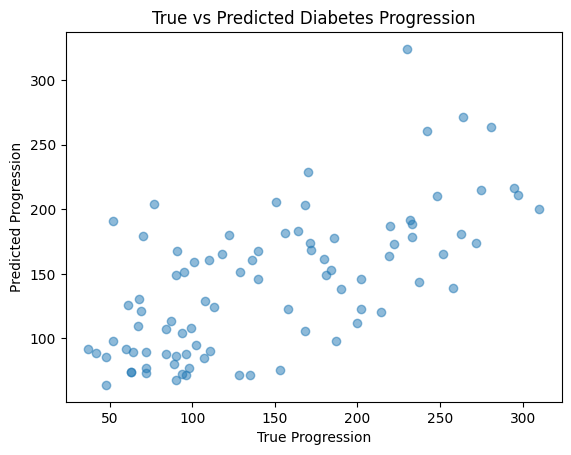

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Dataset Preparation
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 2. Neural Network Definition
class DiabetesNN(nn.Module):
    def __init__(self):
        super(DiabetesNN, self).__init__()
        self.fc1 = nn.Linear(10, 64)  # 10 features in the input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)   # Output layer for regression (1 output neuron)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = DiabetesNN()

# 3. Training
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Log the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        losses.append(loss.item())

# 4. Evaluation
model.eval()
predictions = model(X_test_tensor).detach().numpy()

# Mean Squared Error and R-squared
mse = ((predictions - y_test_tensor.numpy()) ** 2).mean()
ss_total = ((y_test_tensor.numpy() - y_test_tensor.numpy().mean()) ** 2).sum()
ss_residual = ((y_test_tensor.numpy() - predictions) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

# Visualize predictions vs true values
plt.scatter(y_test_tensor.numpy(), predictions, alpha=0.5)
plt.xlabel('True Progression')
plt.ylabel('Predicted Progression')
plt.title('True vs Predicted Diabetes Progression')
plt.show()


Epoch 10/100, Loss: 0.46030721068382263
Epoch 20/100, Loss: 0.38408538699150085
Epoch 30/100, Loss: 0.3520143926143646
Epoch 40/100, Loss: 0.3308603763580322
Epoch 50/100, Loss: 0.3157249987125397
Epoch 60/100, Loss: 0.30937638878822327
Epoch 70/100, Loss: 0.30043625831604004
Epoch 80/100, Loss: 0.2959446609020233
Epoch 90/100, Loss: 0.29469937086105347
Epoch 100/100, Loss: 0.2901473939418793
Accuracy: 0.8679748062015504
Precision: 0.8658892128279884
Recall: 0.8688444661140907
F1 Score: 0.8673643222195181


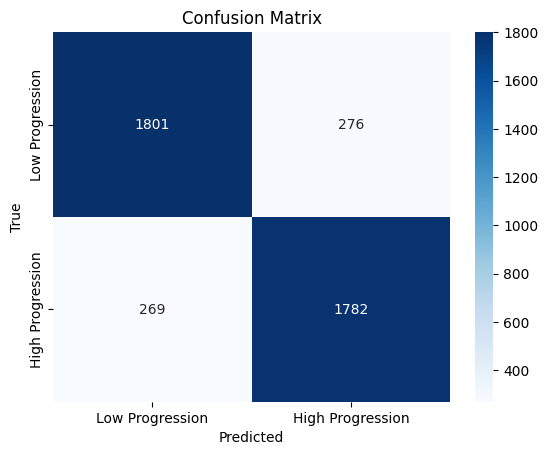

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# 1. Dataset Preparation for Classification
# Create binary labels: 1 for high progression, 0 for low progression
median_progression = np.median(y)
y_binary = (y > median_progression).astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 2. Neural Network Definition for Classification
class DiabetesClassifierNN(nn.Module):
    def __init__(self):
        super(DiabetesClassifierNN, self).__init__()
        self.fc1 = nn.Linear(8, 64)  # Changed input features to 8
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 2 output neurons for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model_classifier = DiabetesClassifierNN()

# 3. Training for Classification
loss_fn_class = nn.CrossEntropyLoss()
optimizer_class = optim.Adam(model_classifier.parameters(), lr=0.01)
epochs = 100

for epoch in range(epochs):
    model_classifier.train()
    optimizer_class.zero_grad()
    output = model_classifier(X_train_tensor)
    loss = loss_fn_class(output, y_train_tensor)
    loss.backward()
    optimizer_class.step()

    # Log the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# 4. Evaluation
model_classifier.eval()
predictions_class = model_classifier(X_test_tensor).detach().numpy()
predicted_labels = predictions_class.argmax(axis=1)

# Metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Progression", "High Progression"], yticklabels=["Low Progression", "High Progression"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Epoch [10/100], Loss: 1.6732
Epoch [20/100], Loss: 0.8427
Epoch [30/100], Loss: 0.6189
Epoch [40/100], Loss: 0.5161
Epoch [50/100], Loss: 0.4474
Epoch [60/100], Loss: 0.4159
Epoch [70/100], Loss: 0.3991
Epoch [80/100], Loss: 0.3881
Epoch [90/100], Loss: 0.3799
Epoch [100/100], Loss: 0.3730
MSE: 0.3851, R2 Score: 0.7061


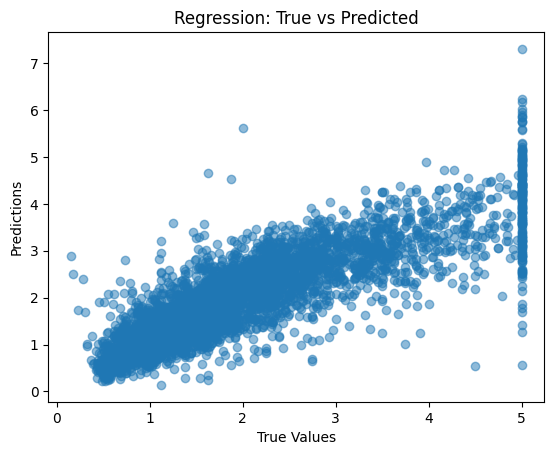

Epoch [10/100], Loss: 0.4547
Epoch [20/100], Loss: 0.3744
Epoch [30/100], Loss: 0.3465
Epoch [40/100], Loss: 0.3293
Epoch [50/100], Loss: 0.3173
Epoch [60/100], Loss: 0.3080
Epoch [70/100], Loss: 0.3016
Epoch [80/100], Loss: 0.2972
Epoch [90/100], Loss: 0.2945
Epoch [100/100], Loss: 0.2899
Accuracy: 0.8675, Precision: 0.8715, Recall: 0.8601, F1-Score: 0.8658


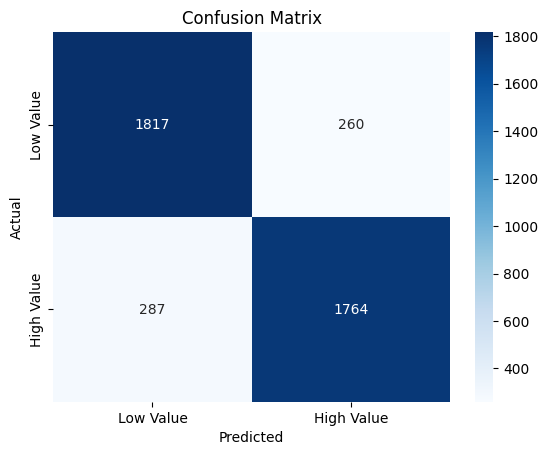

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define Neural Network for Regression
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train Regression Model
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate Regression Model
y_pred = model(X_test_tensor).detach().numpy()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, R2 Score: {r2:.4f}')

# Plot Predictions vs. True Values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Regression: True vs Predicted")
plt.show()

# Classification Task
median_value = np.median(y)  # Define threshold
y_train_class = (y_train > median_value).astype(int)
y_test_class = (y_test > median_value).astype(int)

# Convert to PyTorch tensors
y_train_tensor_class = torch.tensor(y_train_class, dtype=torch.long)
y_test_tensor_class = torch.tensor(y_test_class, dtype=torch.long)

# Define Neural Network for Classification
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train Classification Model
model_class = ClassificationModel()
criterion_class = nn.CrossEntropyLoss()
optimizer_class = optim.Adam(model_class.parameters(), lr=0.01)

for epoch in range(num_epochs):
    optimizer_class.zero_grad()
    outputs = model_class(X_train_tensor)
    loss = criterion_class(outputs, y_train_tensor_class)
    loss.backward()
    optimizer_class.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate Classification Model
y_pred_class = model_class(X_test_tensor).argmax(dim=1).numpy()
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Value', 'High Value'], yticklabels=['Low Value', 'High Value'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
